# Detectron2 Tutorial
In this tutorial, we will use Detectron2 from Facebook AI Research (FAIR) to load our own dataset and train an object detection network.

This tutorial allows you to switch between two different object detector model types:
* RetinaNet for bounding box based object detection
* Mask R-CNN for instance segmentation

These two model arhcitectures are commonly used in practice and both developed by FAIR, hence the out-of-the-box support.

In [ ]:
import os
import cv2
import random
import matplotlib.pyplot as plt
%matplotlib notebook
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## Register Training and Test Datasets
First, we will register our training and test datasets. Detectron2 has utilities to work with datasets formatted in the [COCO dataset](https://cocodataset.org/#home) format, which is commonly used.

**NOTE:** If you need to rerun this section, restart the Jupyter kernel first. Else you will get error messages about the datasets already being registered (assuming you do not change their name).

In [ ]:
from detectron2.data.datasets import load_coco_json, register_coco_instances
from detectron2.data import MetadataCatalog

cur_dir = os.getcwd()
data_dir = os.path.join(cur_dir, "data")

# Training dataset
training_dataset_name = "training_data"
training_json_file = os.path.join(data_dir, "training_annotations.json")
training_img_dir = os.path.join(data_dir, "training_images")
register_coco_instances(training_dataset_name, {}, training_json_file, training_img_dir)
training_dict = load_coco_json(training_json_file, training_img_dir,
                dataset_name=training_dataset_name)
training_metadata = MetadataCatalog.get(training_dataset_name)

# Test dataset
test_dataset_name = "test_data"
test_json_file =  os.path.join(data_dir, "test_annotations.json")
test_img_dir =  os.path.join(data_dir, "test_images")
register_coco_instances(test_dataset_name, {}, test_json_file, test_img_dir)
test_dict = load_coco_json(test_json_file, test_img_dir,
                dataset_name=test_dataset_name)
test_metadata = MetadataCatalog.get(test_dataset_name)

## Display Images from the Training Dataset

<IPython.core.display.Javascript object>


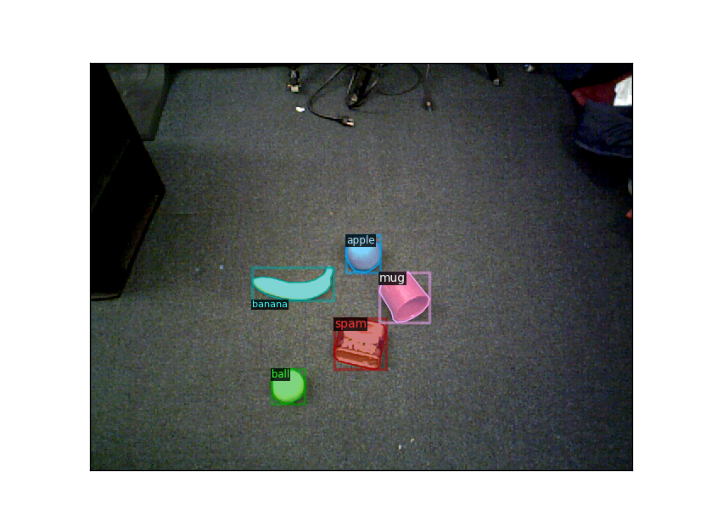

<IPython.core.display.Javascript object>


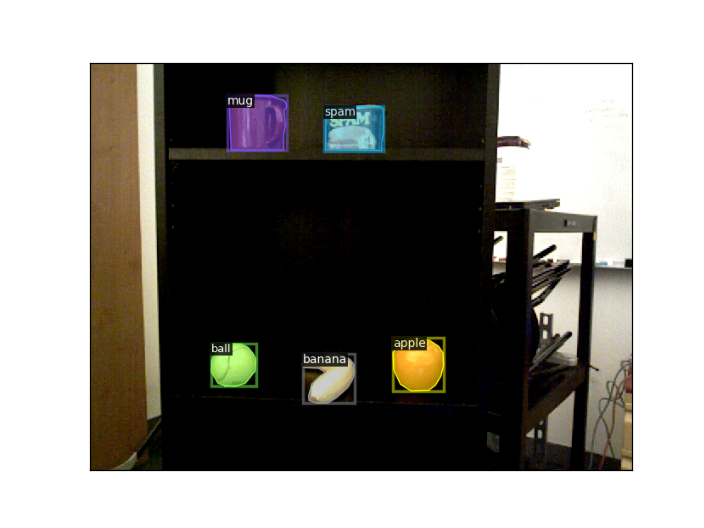

<IPython.core.display.Javascript object>


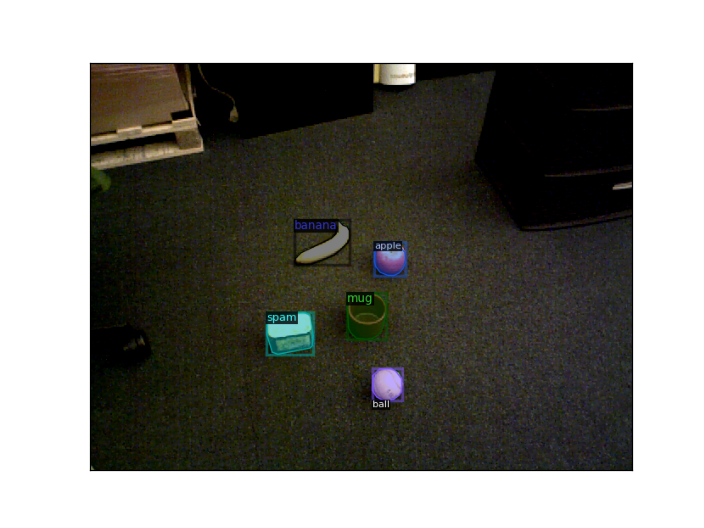

In [11]:
from detectron2.utils.visualizer import Visualizer

NUM_TRAINING_SAMPLES = 3
if NUM_TRAINING_SAMPLES > 0:
    samples = random.sample(training_dict, NUM_TRAINING_SAMPLES)
    for i, sample in enumerate(samples):
        img = cv2.imread(sample["file_name"])
        visualizer = Visualizer(img, metadata=training_metadata)
        visualizer = visualizer.draw_dataset_dict(sample)
        display_img = visualizer.get_image()[:, :, ::-1]
        plt.figure(i+1), plt.xticks([]), plt.yticks([])
        plt.imshow(display_img)

## Set Up Training Options
First, we will start with a benchmark model and weights from the [Detectron2 Model Zoo](https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md).

Additionally, we will set up various training options for our problem. These are listed out in more detail in the [Detectron2 Config References page](https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md), and you should feel free to make modifications as needed.

In [4]:
from detectron2 import model_zoo
from detectron2.config import get_cfg

# Most importantly, let's set up a model type
model_type = "maskrcnn"
if model_type == "maskrcnn":
    model_file = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
elif model_type == "retinanet":
    model_file = "COCO-Detection/retinanet_R_50_FPN_3x.yaml"
    
# Create a configuration and set up the model and datasets
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(model_file))
cfg.DATASETS.TRAIN = (training_dataset_name,)
cfg.DATASETS.TEST = (test_dataset_name,)
cfg.OUTPUT_DIR = f"{model_type}_training_output"
cfg.DATALOADER.NUM_WORKERS = 4
if model_type == "maskrcnn":
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(training_metadata.thing_classes)
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.05
if model_type == "retinanet":
    cfg.MODEL.RETINANET.NUM_CLASSES = len(training_metadata.thing_classes)
    cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.05
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_file)  # Initialize weights from Model Zoo
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # (default: 512)

# Solver options
cfg.SOLVER.BASE_LR = 1e-3           # Base learning rate
cfg.SOLVER.GAMMA = 0.5              # Learning rate decay
cfg.SOLVER.STEPS = (250, 500, 750)  # Iterations at which to decay learning rate
cfg.SOLVER.MAX_ITER = 1000          # Maximum number of iterations
cfg.SOLVER.WARMUP_ITERS = 100       # Warmup iterations to linearly ramp learning rate from zero
cfg.SOLVER.IMS_PER_BATCH = 1        # Lower to reduce memory usage (1 is the lowest)

## Train the Model
While training, you can view progress on Tensorboard. For example, if you are training a Mask R-CNN model:

* In a Terminal, run `tensorboard --logdir=maskrcnn_training_output`
* In your favorite browser, go to `localhost:6006`

In [5]:
from detectron2.data import DatasetMapper, transforms, build_detection_train_loader
from detectron2.engine import DefaultTrainer, SimpleTrainer
from detectron2.engine.hooks import PeriodicWriter

# Custom Trainer class to include custom data augmentations
class Trainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        # Set up data augmentation
        augs = [transforms.ResizeShortestEdge(
                    [640, 672, 704, 736, 768, 800],
                     max_size=1333, sample_style="choice"),
                transforms.RandomBrightness(0.8, 1.2),
                transforms.RandomSaturation(0.8, 1.2),
                transforms.RandomFlip(prob=0.5)]
        data_loader = build_detection_train_loader(cfg,
            mapper=DatasetMapper(cfg, is_train=True, 
                                 augmentations=augs))
        return data_loader
    

# Create an output folder and delete any old files
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
for fname in os.listdir(cfg.OUTPUT_DIR):
    if "tfevents" in fname:
        os.remove(os.path.join(cfg.OUTPUT_DIR, fname))
        
# Create a Trainer using the data augmentations defined above and train the network
# To avoid creating a custom trainer class, you can use 
#  `trainer = SimpleTrainer(cfg)` : A no-frills training pipeline with nothing added  
#  `trainer = DefaultTrainer(cfg)` : The default training pipeline with some data augmentation and hooks
trainer = Trainer(cfg)

# Hack to reduce the printing frequency, which defaults to every 20 iterations..
# There is a cleaner way to do this using `trainer.build_hooks()` but it requires much more effort.
for hook in trainer._hooks:
    if isinstance(hook, PeriodicWriter):
        hook._period = 50
        
# Finally, train the network
trainer.resume_or_load(resume=False)
trainer.train()

[11/23 20:22:50 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[11/23 20:22:50 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=[640, 672, 704, 736, 768, 800], max_size=1333, sample_style='choice'), RandomBrightness(intensity_min=0.8, intensity_max=1.2), RandomSaturation(intensity_min=0.8, intensity_max=1.2), RandomFlip(prob=0.5)]
[11/23 20:22:50 d2.data.datasets.coco]: Loaded 64 images in COCO format from /home/sebastian/robotic_sea_bass/0005_detectron2/detectron2-tutorial/data/training_annotations.json
[11/23 20:22:50 d2.data.build]: Removed 0 images with no usable annotations. 64 images left.
[11/23 20:22:50 d2.data.build]: Distribution of instances among all 5 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|   apple    | 64           |   banana   | 64           |    spam    | 63           |
|    mug     | 64           |    ball    | 64           | 

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (6, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (6,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (20, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (20,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (5, 256, 1, 1) 

[11/23 20:22:50 d2.engine.train_loop]: Starting training from iteration 0
[11/23 20:23:19 d2.utils.events]:  eta: 0:08:58  iter: 49  total_loss: 1.773  loss_cls: 0.5308  loss_box_reg: 0.858  loss_mask: 0.3485  loss_rpn_cls: 0.002097  loss_rpn_loc: 0.009925  time: 0.5685  data_time: 0.0018  lr: 0.00049051  max_mem: 1498M
[11/23 20:23:46 d2.utils.events]:  eta: 0:08:26  iter: 99  total_loss: 0.5717  loss_cls: 0.1372  loss_box_reg: 0.356  loss_mask: 0.07963  loss_rpn_cls: 0.0001298  loss_rpn_loc: 0.01185  time: 0.5588  data_time: 0.0018  lr: 0.00099001  max_mem: 1498M
[11/23 20:24:15 d2.utils.events]:  eta: 0:07:59  iter: 149  total_loss: 0.3695  loss_cls: 0.06793  loss_box_reg: 0.2179  loss_mask: 0.06396  loss_rpn_cls: 6.043e-05  loss_rpn_loc: 0.01654  time: 0.5658  data_time: 0.0017  lr: 0.001  max_mem: 1498M
[11/23 20:24:45 d2.utils.events]:  eta: 0:07:34  iter: 199  total_loss: 0.3064  loss_cls: 0.05637  loss_box_reg: 0.1813  loss_mask: 0.06161  loss_rpn_cls: 0.0001048  loss_rpn_loc: 

## Evaluate Trained Model On Test Set
After training our network, we want to see how it performs on an independent test set.

In [6]:
from detectron2.evaluation import COCOEvaluator

# Load weights from the most recent training run
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

# Run the official Detectron2 test evaluator, which returns useful metrics
if model_type == "maskrcnn":
    eval_tasks = ("segm",)
elif model_type == "retinanet":
    eval_tasks = ("bbox",)
evaluator = COCOEvaluator(test_dataset_name,
                          tasks=eval_tasks,
                          distributed=False,
                          output_dir=os.path.join(f"{model_type}_test_output"))
trainer.test(cfg, trainer.model, evaluators=evaluator)

[11/23 20:35:14 d2.data.datasets.coco]: Loaded 17 images in COCO format from /home/sebastian/robotic_sea_bass/0005_detectron2/detectron2-tutorial/data/test_annotations.json
[11/23 20:35:14 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/23 20:35:14 d2.data.common]: Serializing 17 elements to byte tensors and concatenating them all ...
[11/23 20:35:14 d2.data.common]: Serialized dataset takes 0.03 MiB
[11/23 20:35:14 d2.evaluation.evaluator]: Start inference on 17 images
[11/23 20:35:17 d2.evaluation.evaluator]: Inference done 11/17. 0.2536 s / img. ETA=0:00:01
[11/23 20:35:19 d2.evaluation.evaluator]: Total inference time: 0:00:03.133158 (0.261096 s / img per device, on 1 devices)
[11/23 20:35:19 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:03 (0.251839 s / img per device, on 1 devices)
[11/23 20:35:19 d2.evaluation.coco_evaluation]: Preparing resu

OrderedDict([('segm',
              {'AP': 89.5723674589927,
               'AP50': 97.9756613432241,
               'AP75': 97.9756613432241,
               'APs': 94.98349834983499,
               'APm': 89.18164686216522,
               'APl': 100.0,
               'AP-apple': 92.24422442244226,
               'AP-banana': 88.27145214521451,
               'AP-spam': 84.65033646221765,
               'AP-mug': 89.00770545320785,
               'AP-ball': 93.6881188118812})])

<IPython.core.display.Javascript object>


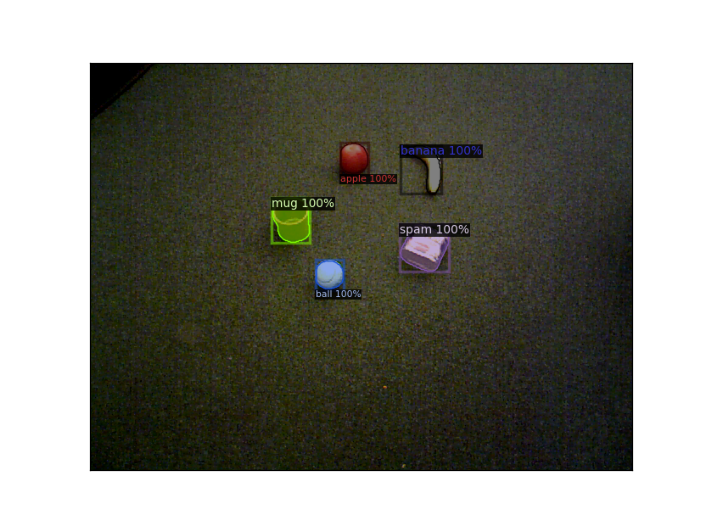

<IPython.core.display.Javascript object>


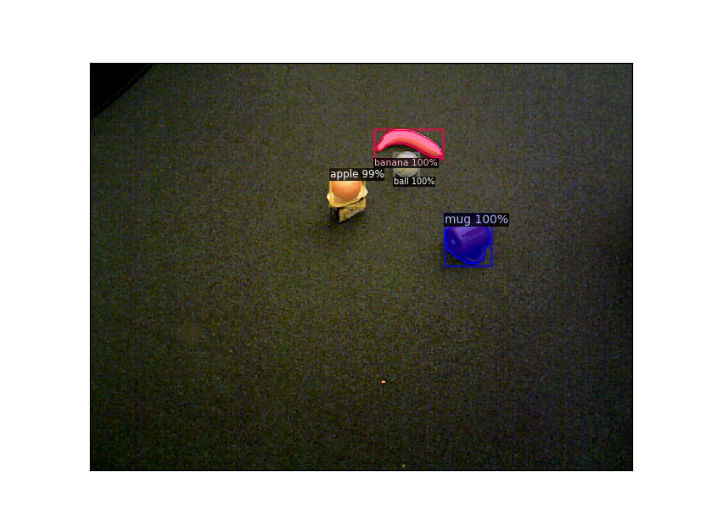

<IPython.core.display.Javascript object>


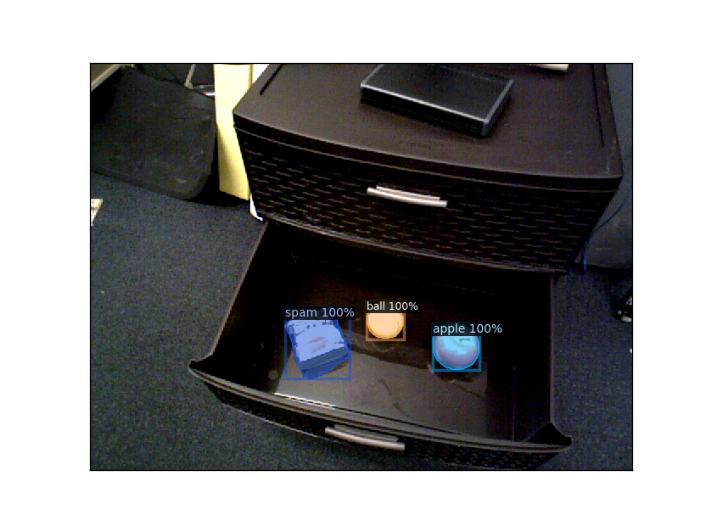

<IPython.core.display.Javascript object>


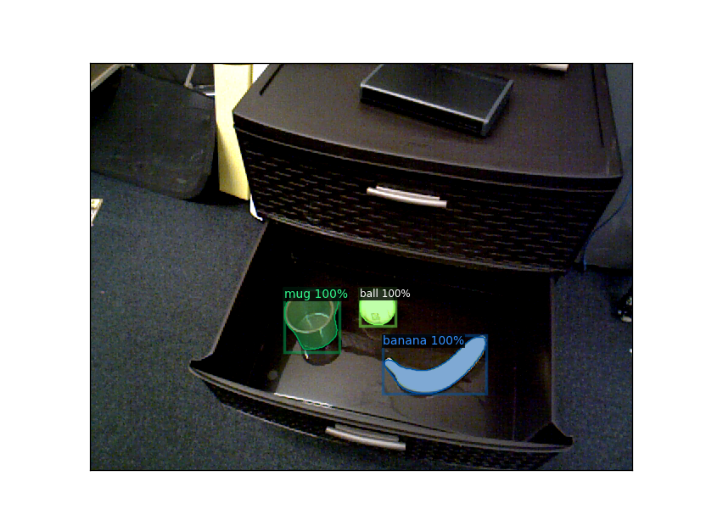

<IPython.core.display.Javascript object>


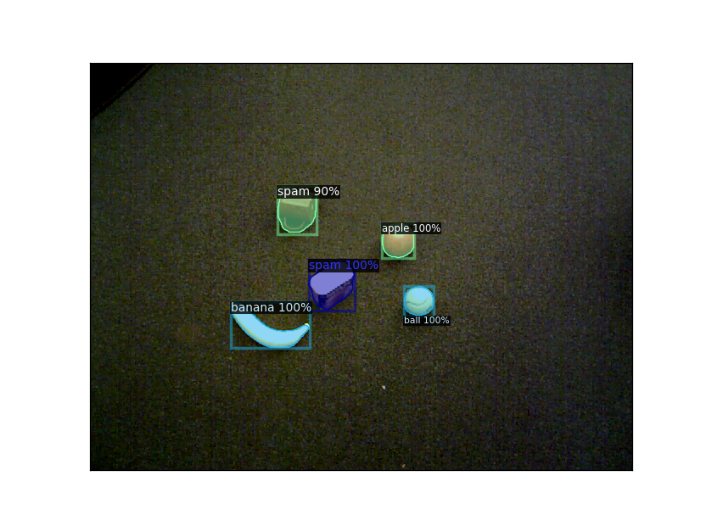

In [10]:
if "trainer" in locals():
    del(trainer) # Free up memory just in case

# Change the prediction score threshold to a bigger value (e.g. 75%)
if model_type == "maskrcnn":
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.75
elif model_type == "retinanet":
    cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.75

# Create a predictor using the trained model    
from detectron2.engine import DefaultPredictor
predictor = DefaultPredictor(cfg)

# Show some qualitative results by predicting on test set images
NUM_TEST_SAMPLES = 5
samples = random.sample(test_dict, NUM_TEST_SAMPLES)
for i, sample in enumerate(samples):
    img = cv2.imread(sample["file_name"])
    outputs = predictor(img)
    visualizer = Visualizer(img, metadata=test_metadata)
    visualizer = visualizer.draw_instance_predictions(
        outputs["instances"].to("cpu"))
    display_img = visualizer.get_image()[:, :, ::-1]
    plt.figure(101+i), plt.xticks([]), plt.yticks([])
    plt.imshow(display_img)